# 1D CO2 Diffusion Model

Liam Kirkpatrick

Feb 15, 2024

IBIS project on water isotope diffusion

This model integrates added functions, including the ability to vary ice thickness and temperature over the course of the mdoel run.

### Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable # allows adding colorbar on line plot

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Define Forward Euler scheme algorithm for solving diffusion equation

Here I draw from: https://hplgit.github.io/fdm-book/doc/pub/diffu/pdf/diffu-4print.pdf and https://zsylvester.github.io/post/diffusion_equation/, and https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ws2016-2017/num_methods_i/heat.pdf.

However, I end up choosing to write my own function here.

In [3]:
def diffusion(t,z,z0,zmax,I,T,thin):
# function
#     Computes diffusion using a 1D euler method approach
# Inputs:
#     t    - vectors of time for the run (UNITS: years)
#     z    - vector of vertical (1D) grid spacing (UNITS: m)
#     z0   - boundary condition, upper side (UNITS: permille)
#     zmax - boundary condition, lower side (UNITS: permille)
#     I    - vector of inital condition (UNITS: permille)
#     T    - Temperature (K)
#     thin - vector of thinning of layers. 
# Outputs:
#     ISO    - matrix of results, where first axis is time and seccond axis is vertical grid (UNITS: permille)

    # Constants
    R = 8.314  # Gas constant, J mol^-1 K^-1
    S = 6.45e-11  # Solubility of CO2 in ice, mol m^-3 Pa^-1
    Do = 9.10e-8 # Diffusion constant of CO2 in ice, m^2 s^-1
    Q = 14700 # J/mol
    gas_content = 0.11 # gas content oin ice, cm^3/g (Severinghaus and Battle, 2006)
    confining_pressure_in_the_atmosphere = 1 # INCORRECT, NEED TO CONFIRM
    rho_ice = 0.917 # density of ice (g/cm^3)

    # calculate porosity
    phi = gas_content / rho_ice / confining_pressure_in_the_atmosphere
    print(phi)
    
    # find dt (convert to secconds)
    dt = (t[1]-t[0]) * 365.25 * 24 * 60 * 60
    
    # find number of timesteps and distance steps
    nt = len(t)
    nz = len(z)
        
    # create matrix of results. Set full of zeros for now
    ISO = np.zeros((nt,nz))
    
    # set first line of matrix to initial conditions, set edges to boundary conditions
    ISO[0,:] = I
    ISO[0,0] = z0
    ISO[0,-1] = zmax
    
    # loop through all timesteps (from 1:end). We don't need to run first timestep as that's the inital conditions
    for j in range(1,nt):

        D = Do * math.exp(-Q/R/T[j])
        if j==1:
            print("D = "+str(D))
        
        # Calculate dz at this timestep. This might change due to thinning.
        dz = (z[1]-z[0]) * thin[j]
        
        # Calculate diffusion coefficent
        D_eff =  D * S * R * T[j] / phi

        if j==1:
            print("Deff = "+str(D_eff))

        # Calculate diffusion coefficient - 
        
        # check stability
        if dt > (0.5*dz**2 / D_eff):
            print("*******************************")
            print("*******************************")
            print("            UNSTABLE           ")
            print("*******************************")
            print("*******************************")
        
        # calculate diffusion number
        d = D_eff * dt / (dz**2)
        
        # loop through all grid points (except left/right side)
        for i in range(1,nz-1):
            
            # solve for gridpoint at this time step
                # this draws on this point, the point above, and the point below at the prior timestep
            ISO[j,i] = ISO[j-1,i] + d * (ISO[j-1,i-1] - 2*ISO[j-1,i] + ISO[j-1,i+1])
            
        # set endpoints
        ISO[j,0] = z0
        ISO[j,-1] = zmax
        
    return(ISO)

### Define initial and boundary conditions, time vector, etc


In [4]:
# set time vector
years = 1.5*10**6
resolution = 5
t = np.linspace(0,years,round(years/resolution)+1)

# set boundary conditions (per mille)
z0 = 300
zmax = 300

# set (inital) space vector. Units of m. Ideal to keep AT LEAST 1cm resolution (so 100x).
meters = 1 # total depth range of sample
gridspace = 0.01 # model resultion, m
z = np.linspace(0,meters,round(meters/gridspace)+1) # make vector. Have to round number of samples to whole number.

# set inital conditions
period_sin = 0.25 # MUST BE EVENLY DIVIDABLE BY GRIDSPACE!
sin_amp = 50
I = np.ones(len(z)) * (z0+zmax)/2
for i in range(len(I)):
    I[i] = I[i] + sin_amp * math.sin(i/(period_sin/gridspace)*2*math.pi)



# set Temperature History
T = np.linspace(243,243,len(t))
#T = np.linspace(265,265,len(t))

# set Thinning history
thin = np.linspace(1,1,len(t))

## Now Run model

In [5]:
run = diffusion(t,z,z0,zmax,I,T,thin)

0.11995637949836423
D = 6.295844349402007e-11
Deff = 6.839221060742808e-17


## Plot Result

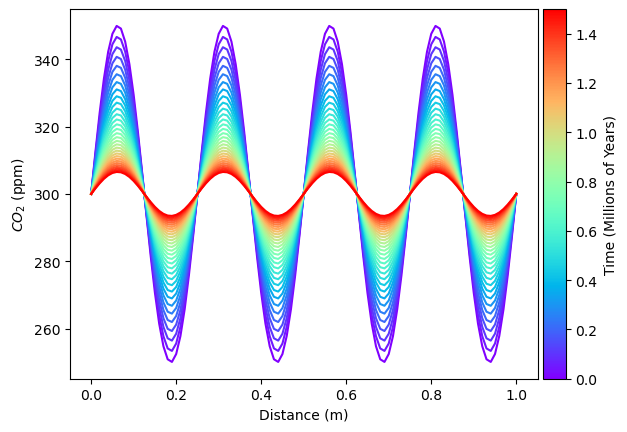

In [6]:
# make figure
fig, axs = plt.subplots(dpi=100)
axs.set_ylabel('$CO_2$ (ppm)')
axs.set_xlabel('Distance (m)')

# set colormap and add colorbar
norm = matplotlib.colors.Normalize(vmin=np.min(t)*10**-6,vmax=np.max(t)*10**-6)
cmap = matplotlib.colormaps.get_cmap('rainbow')
s_m = matplotlib.cm.ScalarMappable(cmap=cmap,norm=norm)
s_m.set_array([])
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(s_m,cax=cax,label='Time (Millions of Years)')

# Plot all time steps
for k in range(0,len(t),10**4): # loop through all time steps

    # plot give time step. Shade by time.
    axs.plot(z,run[k,:],color=cmap(k/len(t)))

### Plot change over time

Not a super useful or intuitive plot, but has it's purposes for debugging. In particular, this will show changes even if the amplitude is near-zero

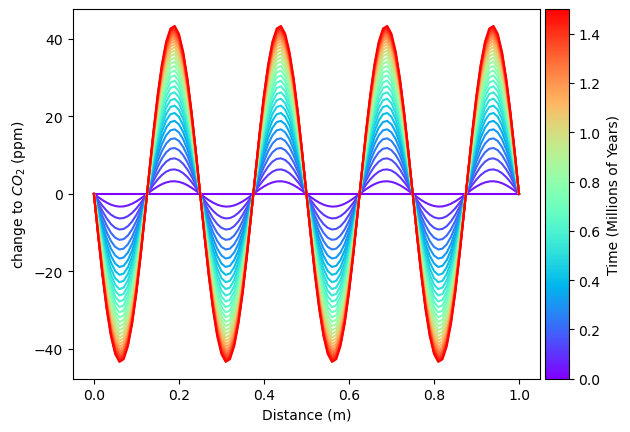

In [7]:
# make figure
fig, axs = plt.subplots(dpi=100)
axs.set_ylabel('change to $CO_2$ (ppm)')
axs.set_xlabel('Distance (m)')

# set colormap and add colorbar
norm = matplotlib.colors.Normalize(vmin=np.min(t)*10**-6,vmax=np.max(t)*10**-6)
cmap = matplotlib.colormaps.get_cmap('rainbow')
s_m = matplotlib.cm.ScalarMappable(cmap=cmap,norm=norm)
s_m.set_array([])
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(s_m,cax=cax,label='Time (Millions of Years)')

# Plot all time steps
for k in range(0,len(t),10**4): # loop through all time steps

    # plot give time step. Shade by time.
    axs.plot(z,run[k,:]-run[0,:],color=cmap(k/len(t)))

### make a plot of amplitude over time

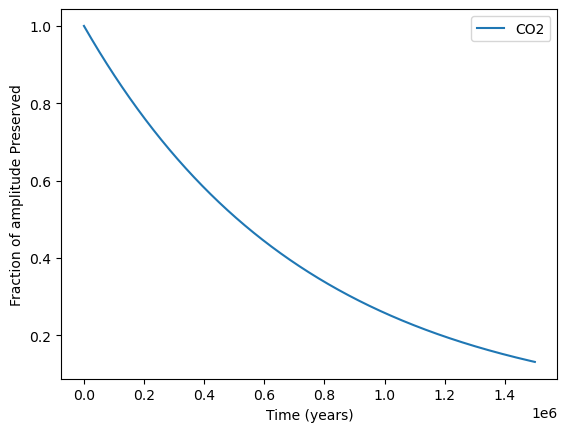

In [19]:
# calculate amplitude at each timestep
amplitude = np.max(run,axis=1)-np.min(run,axis=1)

amp = np.max(run,axis=1)-np.min(run,axis=1)

# Alternatively, a more intutitive but slower way to go about calcualting amplitude:
## make empty vector to store amplitude values
#amplitude = []
## loop through each time step
#for k in range(0,len(t)):
    # at each time step, 
#    amplitude.append(max(run[k,:]) - min(run[k,:]))


### Plot Amplitude over Time ###
# make figure
fig, axs = plt.subplots(dpi=100)
# set axis labels
axs.set_xlabel('Time (years)')
axs.set_ylabel('Fraction of amplitude Preserved')
# plot amplitude
axs.plot(t,amplitude/amplitude[0],label='CO2')
# you could add another curve for water isotopes here, swapping the label and amplitude vector from the line above
# add legend
axs.legend()